# V.5
- ResNet50 사용
- 이미지 상단 제목 데이터 추가

In [1]:
import pandas as pd
import numpy as np
import os
import time
import random
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import timm
import torch
import albumentations as A
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import accuracy_score, f1_score

import wandb

import warnings
warnings.filterwarnings("ignore")

In [2]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
device

device(type='cuda')

# CustomDataset

In [5]:
class customdataset(torch.utils.data.Dataset):
    def __init__(self, csv, path, transforms):
        super().__init__()
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transforms = transforms

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        img = self.transforms(img)
    
        return img, target

In [6]:
'''
class GaussianNoise:
    def __init__(self, mean, std_range):
        self.mean = mean
        self.std_range = std_range

    def __call__(self, tensor):
        std = random.uniform(*self.std_range)
        noise = torch.randn(tensor.size())*std + self.mean
        return tensor + noise
'''

class RandomPadding:
    def __init__(self, padding_range=(0, 50), fill=0):
        self.padding_range = padding_range
        self.fill = fill

    def __call__(self, image):
        # 각 방향에 대해 랜덤한 패딩 값 생성
        pad_top = random.randint(*self.padding_range)
        pad_bottom = random.randint(*self.padding_range)
        pad_left = random.randint(*self.padding_range)
        pad_right = random.randint(*self.padding_range)
        
        # 패딩 추가
        padding = (pad_left, pad_top, pad_right, pad_bottom)
        return T.functional.pad(image, padding, fill=self.fill)

'''
# 랜덤 정규화 변환 클래스
class RandomNormalize:
    def __init__(self, mean_range, std_range):
        self.mean_range = mean_range
        self.std_range = std_range

    def __call__(self, tensor):
        # 각 채널에 대한 랜덤한 mean과 std 생성
        mean = [random.uniform(*self.mean_range) for _ in range(3)]
        std = [random.uniform(*self.std_range) for _ in range(3)]
        # 정규화 적용
        tensor = T.functional.normalize(tensor, mean=mean, std=std)
        return tensor
'''

'\n# 랜덤 정규화 변환 클래스\nclass RandomNormalize:\n    def __init__(self, mean_range, std_range):\n        self.mean_range = mean_range\n        self.std_range = std_range\n\n    def __call__(self, tensor):\n        # 각 채널에 대한 랜덤한 mean과 std 생성\n        mean = [random.uniform(*self.mean_range) for _ in range(3)]\n        std = [random.uniform(*self.std_range) for _ in range(3)]\n        # 정규화 적용\n        tensor = T.functional.normalize(tensor, mean=mean, std=std)\n        return tensor\n'

In [8]:
aug_transforms = T.Compose([
    T.ToTensor(),
    T.RandomRotation(180),
    T.RandomHorizontalFlip(p=0.5),
    RandomPadding(padding_range=(10, 20), fill=50),  # 랜덤 패딩 추가
    T.RandomResizedCrop(size=(550,550), scale=(0.5, 1.0)),
    T.Resize((600, 600))
])

simple_transforms = T.Compose([
    T.ToTensor(),
    T.RandomRotation(180),
    T.RandomHorizontalFlip(p=0.5),
    RandomPadding(padding_range=(50, 50), fill=50),
    T.RandomResizedCrop(size=(550,550), scale=(0.5, 1.0)),
    T.Resize((600, 600))
])

origin_transforms = T.Compose([
    T.ToTensor(),
    T.Resize((600, 600))
    ])

# augraphy 적용 + 간단한 transforms 적용
aug_dataset_1 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy2/augmented1', transforms=aug_transforms)
aug_dataset_2 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy2/augmented2', transforms=aug_transforms)
aug_dataset_3 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy2/augmented3', transforms=aug_transforms)
aug_dataset_4 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy2/augmented4', transforms=aug_transforms) 
aug_dataset_5 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy2/augmented5', transforms=aug_transforms) # V.5.3
aug_dataset_6 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy2/augmented6', transforms=aug_transforms)
aug_dataset_7 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy2/augmented7', transforms=aug_transforms)
aug_dataset_8 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy2/augmented8', transforms=aug_transforms)
aug_dataset_9 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy2/augmented9', transforms=aug_transforms) # V.5, V.5.2
aug_dataset_10 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy2/augmented10', transforms=aug_transforms) 
aug_dataset_11 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy2/augmented11', transforms=aug_transforms)
aug_dataset_12 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy2/augmented12', transforms=aug_transforms)
aug_dataset_13 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy2/augmented13', transforms=aug_transforms)
aug_dataset_14 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy2/augmented14', transforms=aug_transforms)
aug_dataset_15 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy2/augmented15', transforms=aug_transforms)
aug_dataset_16 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy2/augmented16', transforms=aug_transforms)
aug_dataset_17 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy2/augmented17', transforms=aug_transforms)
aug_dataset_18 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy2/augmented18', transforms=aug_transforms)
aug_dataset_19 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy2/augmented19', transforms=aug_transforms)
aug_dataset_20 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy2/augmented20', transforms=aug_transforms)
aug_dataset_21 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy2/augmented21', transforms=aug_transforms)
aug_dataset_22 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy2/augmented22', transforms=aug_transforms)
aug_dataset_23 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy2/augmented23', transforms=aug_transforms)
aug_dataset_24 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy2/augmented24', transforms=aug_transforms)
aug_dataset_25 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy2/augmented25', transforms=aug_transforms)


# 간단한 transforms 적용
simple_aug_dataset_1 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=simple_transforms)
simple_aug_dataset_2 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=simple_transforms)
simple_aug_dataset_3 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=simple_transforms)
simple_aug_dataset_4 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=simple_transforms)
simple_aug_dataset_5 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=simple_transforms) # V.5, V.5.3
simple_aug_dataset_6 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=simple_transforms) 
simple_aug_dataset_7 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=simple_transforms)
simple_aug_dataset_8 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=simple_transforms)
simple_aug_dataset_9 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=simple_transforms)
simple_aug_dataset_10 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=simple_transforms)
simple_aug_dataset_11 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=simple_transforms)
simple_aug_dataset_12 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=simple_transforms)
simple_aug_dataset_13 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=simple_transforms)
simple_aug_dataset_14 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=simple_transforms)
simple_aug_dataset_15 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=simple_transforms) # V.5.2


# 완전 원본 데이터
origin_dataset_1 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=origin_transforms) # V.5, V.5.3
origin_dataset_2 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=origin_transforms)
origin_dataset_3 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=origin_transforms) # V.5.2

# 추출한 제목: augraphy 적용 + 간단한 transforms 적용
title_aug_dataset_1 = customdataset('/data/ephemeral/home/data/title_df.csv', '/data/ephemeral/home/data/Augmentation/title_augraphy/augmented1', transforms=aug_transforms)
title_aug_dataset_2 = customdataset('/data/ephemeral/home/data/title_df.csv', '/data/ephemeral/home/data/Augmentation/title_augraphy/augmented2', transforms=aug_transforms)
title_aug_dataset_3 = customdataset('/data/ephemeral/home/data/title_df.csv', '/data/ephemeral/home/data/Augmentation/title_augraphy/augmented3', transforms=aug_transforms)

# 제목 완전 원본
title_origin_dataset_1 = customdataset('/data/ephemeral/home/data/title_df.csv', '/data/ephemeral/home/data/Augmentation/title_extracted', transforms=simple_transforms)
title_origin_dataset_2 = customdataset('/data/ephemeral/home/data/title_df.csv', '/data/ephemeral/home/data/Augmentation/title_extracted', transforms=simple_transforms)
title_origin_dataset_3 = customdataset('/data/ephemeral/home/data/title_df.csv', '/data/ephemeral/home/data/Augmentation/title_extracted', transforms=simple_transforms)

In [9]:
len(title_origin_dataset_1)

870

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..50.0].


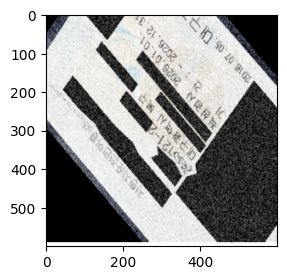

In [10]:
plt.figure(figsize=(3, 3))
plt.imshow(aug_dataset_2[10][0].permute(1, 2, 0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..50.0].


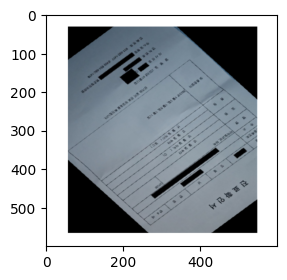

In [15]:
plt.figure(figsize=(3, 3))
plt.imshow(simple_aug_dataset_9[15][0].permute(1, 2, 0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..50.0].


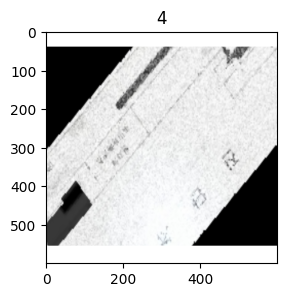

In [15]:
plt.figure(figsize=(3, 3))
plt.imshow(title_aug_dataset_3[100][0].permute(1, 2, 0))
plt.title(title_origin_dataset_3[100][1])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..50.0].


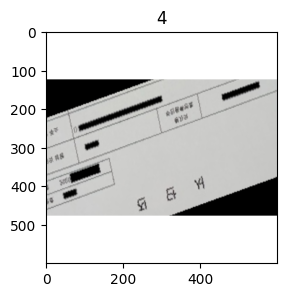

In [16]:
plt.figure(figsize=(3, 3))
plt.imshow(title_origin_dataset_3[100][0].permute(1, 2, 0))
plt.title(title_origin_dataset_3[100][1])
plt.show()

In [13]:
train_dataset = torch.utils.data.ConcatDataset([aug_dataset_1, aug_dataset_2, aug_dataset_3, 
                                                aug_dataset_4, aug_dataset_5,

                                                simple_aug_dataset_1, simple_aug_dataset_2, simple_aug_dataset_3,
                                                simple_aug_dataset_4, simple_aug_dataset_5,

                                                origin_dataset_1])

In [14]:
len(train_dataset)

17270

# valid dataset

### train data 중 일부 사용

In [15]:
total_num = len(train_dataset)
train_num, valid_num = int(total_num*0.9), int(total_num*0.1)

train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_num, valid_num])

In [16]:
print(len(train_dataset), len(valid_dataset))

15543 1727


### v.1.3의 예측 결과 사용

In [64]:
valid_transforms = T.Compose([
    T.ToTensor(),
    T.Resize((600, 600))
])

valid_dataset = customdataset('/data/ephemeral/home/preds/v1_3_preds.csv', '/data/ephemeral/home/data/test/', transforms=valid_transforms) # valid dataset

In [65]:
len(train_dataset)

27030

In [66]:
len(valid_dataset)

3140

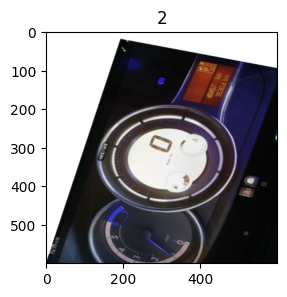

In [70]:
plt.figure(figsize=(3, 3))
plt.imshow(valid_dataset[0][0].permute(1, 2, 0))
plt.title(valid_dataset[0][1])
plt.show()

In [17]:
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=16)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size, shuffle=False, num_workers=16)

# 학습

### 학습전 모델 이름 바꿔주기!!

In [18]:
def training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        max_prob, predicted = torch.max(outputs, 1)
        train_accuracy += (predicted == labels).sum().item()

        tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}')

    train_loss = train_loss / len(train_dataloader)
    train_accuracy = train_accuracy / len(train_dataset)

    return model, train_loss, train_accuracy

def evalutaion(model, valid_dataloader, valid_accuracy, criterion, epoch, num_epochs):
    model.eval()
    valid_loss = 0.0
    valid_accuracy = 0

    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            max_prob, predicted = torch.max(outputs, 1)
            valid_accuracy += (predicted == labels).sum().item()

            tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}], Valid Loss: {loss.item():.4f}')

    valid_loss = valid_loss / len(valid_dataloader)
    valid_accuracy = valid_accuracy / len(valid_dataset)

    return model, valid_loss, valid_accuracy

def training_loop(model, train_dataloader, train_dataset, valid_dataloader, valid_dataset, criterion, optimizer, num_epochs):
    best_valid_loss = float('inf')
    early_stop_cnt = 0
    valid_max_accuracy = -1

    for epoch in range(num_epochs):
        model, train_loss, train_accuracy = training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs)
        model, valid_loss, valid_accuracy = evalutaion(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs)

        #monitoring_values = {'Train Loss': train_loss, 'Valid Loss': valid_loss, 'Train Accuracy': train_accuracy, 'Valid Accuracy': valid_accuracy}
        #run.log(monitoring_values, step=epoch)

        if valid_accuracy > valid_max_accuracy:
            valid_max_accuracy = valid_accuracy

        if valid_loss < best_valid_loss:
            torch.save(model.state_dict(), f"/data/ephemeral/home/model/models/model_v5_3_best.pt")
            best_valid_loss = valid_loss
            early_stop_cnt = 0

        else :
            early_stop_cnt += 1

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}")

        if early_stop_cnt >= 10:
            torch.save(model.state_dict(), f"/data/ephemeral/home/model/models/model_v5_3_last.pt")
            print('Early Stopping')
            break

    return model

In [19]:
model = timm.create_model(
    'resnet50',
    pretrained=True,
    num_classes=17
).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [20]:
model = training_loop(model, train_dataloader, train_dataset, valid_dataloader, valid_dataset, criterion, optimizer, 100)

  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [1/100], Train Loss: 0.7817, Train Accuracy: 0.7350 Valid Loss: 0.9401, Valid Accuracy: 0.6850


  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [2/100], Train Loss: 0.2651, Train Accuracy: 0.9034 Valid Loss: 1.0265, Valid Accuracy: 0.6920


  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [3/100], Train Loss: 0.1949, Train Accuracy: 0.9302 Valid Loss: 0.7994, Valid Accuracy: 0.7446


  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [4/100], Train Loss: 0.1521, Train Accuracy: 0.9454 Valid Loss: 0.5580, Valid Accuracy: 0.8164


  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [5/100], Train Loss: 0.1195, Train Accuracy: 0.9566 Valid Loss: 0.6649, Valid Accuracy: 0.7811


  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [6/100], Train Loss: 0.1121, Train Accuracy: 0.9614 Valid Loss: 0.6016, Valid Accuracy: 0.8396


  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [7/100], Train Loss: 0.0944, Train Accuracy: 0.9658 Valid Loss: 0.6154, Valid Accuracy: 0.8083


  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [8/100], Train Loss: 0.0869, Train Accuracy: 0.9701 Valid Loss: 0.0960, Valid Accuracy: 0.9710


  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [9/100], Train Loss: 0.0638, Train Accuracy: 0.9787 Valid Loss: 2.3179, Valid Accuracy: 0.6387


  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [10/100], Train Loss: 0.0690, Train Accuracy: 0.9763 Valid Loss: 1.2659, Valid Accuracy: 0.6815


  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [11/100], Train Loss: 0.0629, Train Accuracy: 0.9782 Valid Loss: 0.5215, Valid Accuracy: 0.8280


  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [12/100], Train Loss: 0.0562, Train Accuracy: 0.9799 Valid Loss: 0.2229, Valid Accuracy: 0.9305


  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [13/100], Train Loss: 0.0598, Train Accuracy: 0.9797 Valid Loss: 0.7242, Valid Accuracy: 0.7956


  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [14/100], Train Loss: 0.0492, Train Accuracy: 0.9831 Valid Loss: 0.2401, Valid Accuracy: 0.9247


  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [15/100], Train Loss: 0.0561, Train Accuracy: 0.9822 Valid Loss: 0.2921, Valid Accuracy: 0.9276


  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [16/100], Train Loss: 0.0403, Train Accuracy: 0.9866 Valid Loss: 1.0235, Valid Accuracy: 0.8095


  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [17/100], Train Loss: 0.0495, Train Accuracy: 0.9829 Valid Loss: 0.2204, Valid Accuracy: 0.9375


  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [18/100], Train Loss: 0.0485, Train Accuracy: 0.9838 Valid Loss: 0.1927, Valid Accuracy: 0.9357
Early Stopping


# Test

In [ ]:
model.eval()
test_loss = 0.0
test_accuracy = 0

all_preds = []

with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        max_prob, predicted = torch.max(outputs, 1)
        test_accuracy += (predicted == labels).sum().item()

        all_preds.extend(predicted)

test_loss = test_loss / len(test_dataloader)
test_accuracy = test_accuracy / len(test_dataset)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

NameError: name 'test_dataloader' is not defined

In [ ]:
plt.figure(figsize=(20, 20))

for i in range(20, 40):
    ax = plt.subplot(4, 5, (i%20)+1)

    plt.imshow(test_dataset[i][0].permute(1, 2, 0))
    plt.title(f'real: {test_dataset[i][1]}\npred: {all_preds[i].cpu()}')

# Submission

In [5]:
model = timm.create_model(
    'resnet50',
    pretrained=True,
    num_classes=17
).to(device)
model.load_state_dict(torch.load('/data/ephemeral/home/model/models/model_v5_3_best.pt'))

criterion = torch.nn.CrossEntropyLoss()

In [6]:
class sub_customdataset(torch.utils.data.Dataset):
    def __init__(self, csv, path, transforms):
        super().__init__()
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transforms = transforms

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        img = self.transforms(img)
    
        return img, target

In [7]:
transforms = T.Compose([
    T.ToTensor(),
    T.Resize((600, 600))
])

sub_dataset = sub_customdataset('/data/ephemeral/home/data/sample_submission.csv', '/data/ephemeral/home/data/test/', transforms=transforms)

In [8]:
batch_size = 32

sub_dataloader = torch.utils.data.DataLoader(sub_dataset, batch_size=batch_size, shuffle=False, num_workers=16)

In [9]:
model.eval()

all_preds = []
all_labels = []
all_images = []

with torch.no_grad():
    tbar = tqdm(sub_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        max_prob, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted)
        all_labels.extend(labels)
        all_images.extend(images)


  0%|          | 0/99 [00:00<?, ?it/s]

In [10]:
all_preds

[tensor(2, device='cuda:0'),
 tensor(6, device='cuda:0'),
 tensor(5, device='cuda:0'),
 tensor(7, device='cuda:0'),
 tensor(2, device='cuda:0'),
 tensor(15, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(8, device='cuda:0'),
 tensor(15, device='cuda:0'),
 tensor(11, device='cuda:0'),
 tensor(5, device='cuda:0'),
 tensor(7, device='cuda:0'),
 tensor(16, device='cuda:0'),
 tensor(9, device='cuda:0'),
 tensor(15, device='cuda:0'),
 tensor(4, device='cuda:0'),
 tensor(10, device='cuda:0'),
 tensor(5, device='cuda:0'),
 tensor(13, device='cuda:0'),
 tensor(6, device='cuda:0'),
 tensor(12, device='cuda:0'),
 tensor(12, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(6, device='cuda:0'),
 tensor(3, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(3, device='cuda:0'),
 tensor(16, device='cuda:0'),
 tensor(6, device='cuda:0'),
 tensor(6, device='cuda:0'),
 tensor(3, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(13, device='cuda:0'),
 tensor(2, device='cuda:0'),
 te

In [11]:
sub_df = pd.read_csv('/data/ephemeral/home/data/sample_submission.csv')
sub_df

,ID,target
0,0008fdb22ddce0ce.jpg,0
1,00091bffdffd83de.jpg,0
2,00396fbc1f6cc21d.jpg,0
3,00471f8038d9c4b6.jpg,0
4,00901f504008d884.jpg,0
...,...,...
3135,ffb4b6f619fb60ea.jpg,0
3136,ffb54299b1ad4159.jpg,0
3137,ffc2c91dff8cf2c0.jpg,0
3138,ffc4e330a5353a2a.jpg,0


In [12]:
for i in range(3140):
    sub_df.iloc[i, 1] = int(all_preds[i].cpu())

In [13]:
sub_df.to_csv('/data/ephemeral/home/preds/v5_3_best_preds.csv', index=False)